In [31]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import skadipy as sk
from skadipy.allocator import reference_filters as rf

ma_bow_port = sk.actuator.Azimuth(
    position=sk.toolbox.Point([1.8, -0.8, 0.0]),
    orientation=sk.toolbox.Quaternion(
        axis=(0.0, 0.0, 1.0), angle=(-np.pi / 4)
    ),
    extra_attributes={
        "rate_limit": 10,
        "saturation_limit": 100.0,
    }
)

ma_bow_starboard = sk.actuator.Azimuth(
    position=sk.toolbox.Point([1.8, 0.8, 0.0]),
    orientation=sk.toolbox.Quaternion(
        axis=(0.0, 0.0, 1.0), angle=(np.pi / 4)
    ),
    extra_attributes={
        "rate_limit": 10.0,
        "saturation_limit": 100.0,
    }
)

ma_stern_starboard = sk.actuator.Azimuth(
    position=sk.toolbox.Point([-1.8, 0.8, 0.0]),
    orientation=sk.toolbox.Quaternion(
        axis=(0.0, 0.0, 1.0), angle=(3 * np.pi / 4)
    ),
    extra_attributes={
        "rate_limit": 10,
        "saturation_limit": 100.0,
    }
)

ma_stern_port = sk.actuator.Azimuth(
    position=sk.toolbox.Point([-1.8, -0.8, 0.0]),
    orientation=sk.toolbox.Quaternion(
        axis=(0.0, 0.0, 1.0), angle=(-3 * np.pi / 4)
    ),
    extra_attributes={
        "rate_limit": 10,
        "saturation_limit": 100.0,
    }
)

actuators=[
    ma_bow_port,
    ma_bow_starboard,
    ma_stern_starboard,
    ma_stern_port,
]

In [32]:
ref_filter_allocator = rf.MinimumMagnitudeAndAzimuth(
    actuators=actuators,
    force_torque_components=[
        sk.allocator.ForceTorqueComponent.X,
        sk.allocator.ForceTorqueComponent.Y,
        sk.allocator.ForceTorqueComponent.N,
    ],
    gamma=0.2,
    mu=10,
    rho=0.1,
    time_step=0.01,
    control_barrier_function=sk.safety.ControlBarrierFunctionType.ABSOLUTE
)

In [33]:
ref_filter_allocator.compute_configuration_matrix()
alpha1_list = []
alpha2_list = []
alpha3_list = []
alpha4_list = []
force1_list = []
force2_list = []
force3_list = []
force4_list = []

tau = np.array([[0.0, 10.0, 0.0, 0.0, 0.0, 0.0]]).T
time_arr = np.arange(0, 10, 0.01)
for i in range(len(time_arr)):
    force = ref_filter_allocator.allocate(tau=tau)[0]
    alpha1 = np.arctan2(force[1], force[0])
    alpha2 = np.arctan2(force[3], force[2])
    alpha3 = np.arctan2(force[5], force[4])
    alpha4 = np.arctan2(force[7], force[6])
    alpha1_list.append(np.rad2deg(alpha1))
    alpha2_list.append(np.rad2deg(alpha2))
    alpha3_list.append(np.rad2deg(alpha3))
    alpha4_list.append(np.rad2deg(alpha4))

    force1_list.append(np.linalg.norm(force[0:2]))
    force2_list.append(np.linalg.norm(force[2:4]))
    force3_list.append(np.linalg.norm(force[4:6]))
    force4_list.append(np.linalg.norm(force[6:8]))

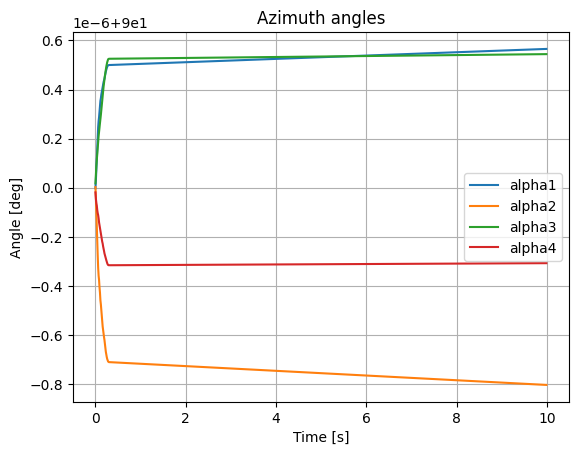

In [34]:
plt.figure()
plt.plot(time_arr, alpha1_list, label="alpha1")
plt.plot(time_arr, alpha2_list, label="alpha2")
plt.plot(time_arr, alpha3_list, label="alpha3")
plt.plot(time_arr, alpha4_list, label="alpha4")
plt.xlabel("Time [s]")
plt.ylabel("Angle [deg]")
plt.legend()
plt.grid()
plt.title("Azimuth angles")
plt.show()

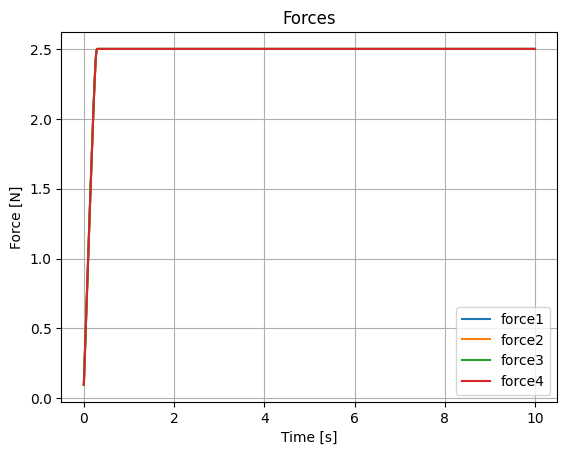

In [35]:
plt.figure()
plt.plot(time_arr, force1_list, label="force1")
plt.plot(time_arr, force2_list, label="force2")
plt.plot(time_arr, force3_list, label="force3")
plt.plot(time_arr, force4_list, label="force4")
plt.xlabel("Time [s]")
plt.ylabel("Force [N]")
plt.legend()
plt.grid()
plt.title("Forces")
plt.show()

{1: 1.5707963366651867, 2: 1.5707963127829603, 3: 1.5707963362949078, 4: 1.5707963214365346}


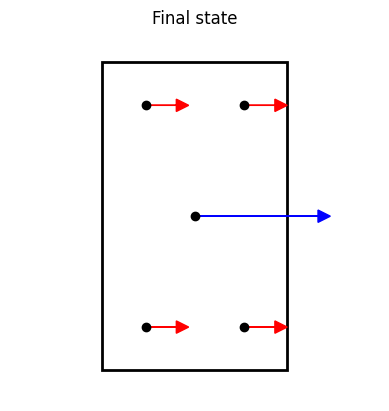

In [36]:
vessel_length = 5
vessel_width = 3

fig, ax = plt.subplots()

vessel_rect = patches.Rectangle((-vessel_width/2, -vessel_length/2),
                                vessel_width, vessel_length,
                                fill=False, edgecolor='black', lw=2)
ax.add_patch(vessel_rect)

thruster_positions = {
    1: (1.8, -0.8),
    2: (1.8, 0.8),
    3: (-1.8, 0.8),
    4: (-1.8, -0.8)
}

thruster_angles = {
    1: alpha1[0],
    2: alpha2[0],  
    3: alpha3[0],
    4: alpha4[0]
}

print(thruster_angles)

arrow_length = 0.8
head_width = 0.2
head_length = 0.2

arrow_scaling = 0.2
# print(force1_list[-1])
forces = [force1_list[-1], force2_list[-1], force3_list[-1], force4_list[-1]]
for thruster, pos in thruster_positions.items():
    angle = thruster_angles[thruster]
    force = forces[thruster - 1]
    dx = force * np.cos(angle) * arrow_scaling
    dy = force * np.sin(angle) * arrow_scaling
    ax.arrow(pos[1], pos[0], dy, dx, head_width=head_width, head_length=head_length,
             fc='red', ec='red')
    ax.plot(pos[1], pos[0], 'ko')

# Add the desired tau to the figure
angle = np.arctan2(tau[1], tau[0])[0]
force = np.linalg.norm(tau[0:2])
dx = force * np.cos(angle) * arrow_scaling
dy = force * np.sin(angle) * arrow_scaling
ax.arrow(0, 0, dy, dx, head_width=head_width, head_length=head_length,
         fc='blue', ec='blue')
ax.plot(0, 0, 'ko')

ax.set_aspect('equal')
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.set_xlabel('y')
ax.set_ylabel('x')
ax.set_title('Final state')
ax.axis('off')

plt.show()